In [2]:
import tensorflow as tf
import numpy as np
import os
# 从硬盘或者网络连接读取文件存到的.keras\datasets下。
path_to_file = tf.keras.utils.get_file("poetry.txt","file:///D:/pythonprojects/NLP/大作业/poetry.txt")
# 读取文本内容
text = open(path_to_file, 'rb').read().decode(encoding='gbk')
# 打印出来
# print(text)

In [3]:
# 列举文本中的非重复字符即字库
vocab = sorted(set(text))
# 字库保存到文件，以后使用直接拿，不用再去计算
np.save('vocab.npy',vocab)
#word2vec
word2vec = {u:i for i, u in enumerate(vocab)}

# 创建从索引到非重复字符的映射
idx2char = np.array(vocab) # 一个数组 ['龙' ... '龚' '龛' '龟']，根据数能找到字
# 将训练文件内容转换为索引的数据
# 全部文本转换为数字 [1020 4914 3146 ... 4731 2945    0]
text_as_int = np.array([word2vec[c] for c in text])


In [4]:
# 处理一句段文本，拆分为输入和输出两段
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

# 创建训练样本，将转化为数字的诗句外面套一层壳子，原来是[x]
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
# 所有样本中，每24个字作为一组
sequences = char_dataset.batch(24, drop_remainder=True) # 数据当前状态：((24,x))
# 将每24个字作为一组所有样本，掐头去尾转为输入，输出结对
dataset = sequences.map(split_input_target) # 数据当前状态：((23,x), (23,x))

# 将众多输入输出对打散，并64个为一组
BATCH_SIZE = 64
# 数据当前状态：((64, 23), (64, 23))
dataset = dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)
# 获取一批训练的输入，输出
train_batch, train_labels = next(iter(dataset))

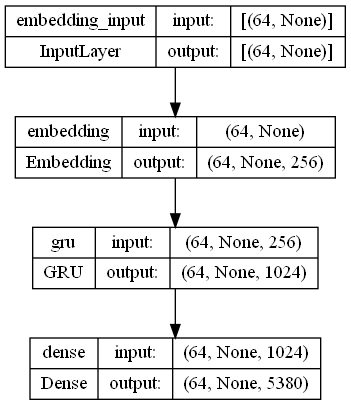

In [5]:
from tensorflow.keras.utils import plot_model
# 构建一个模型的方法
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)])
    return model

# 词集的长度,也就是字典的大小
vocab_size = len(vocab)
# 嵌入的维度，也就是生成的embedding的维数
embedding_dim = 256
# RNN 的单元数量
rnn_units = 1024

# 整一个模型
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

# 损失函数
def loss(labels, logits):
      return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# 配置优化器和损失函数
model.compile(optimizer='adam', loss=loss)
plot_model(model, to_file='模型.png', show_shapes=True)

In [5]:
# 训练结果保存的目录
checkpoint_dir = './training_checkpoints'
# 文件名 ckpt_训练轮数
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
# 训练的回调
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)
# 进行训练
history = model.fit(dataset, epochs=20, callbacks=[checkpoint_callback])

Epoch 1/20


2022-10-20 15:34:55.156815: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22036480 exceeds 10% of free system memory.
2022-10-20 15:34:55.177774: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22036480 exceeds 10% of free system memory.


565/565 [==============================] - 610s 1s/step - loss: 5.6329
Epoch 2/20
565/565 [==============================] - 625s 1s/step - loss: 4.7665
Epoch 3/20
565/565 [==============================] - 621s 1s/step - loss: 4.3784
Epoch 4/20
565/565 [==============================] - 651s 1s/step - loss: 4.0650
Epoch 5/20
565/565 [==============================] - 630s 1s/step - loss: 3.7570
Epoch 6/20
565/565 [==============================] - 656s 1s/step - loss: 3.4425
Epoch 7/20
565/565 [==============================] - 653s 1s/step - loss: 3.1349
Epoch 8/20
565/565 [==============================] - 591s 1s/step - loss: 2.8533
Epoch 9/20
565/565 [==============================] - 591s 1s/step - loss: 2.6024
Epoch 10/20
565/565 [==============================] - 590s 1s/step - loss: 2.3897
Epoch 11/20
565/565 [==============================] - 590s 1s/step - loss: 2.2107
Epoch 12/20
565/565 [==============================] - 590s 1s/step - loss: 2.0599
Epoch 13/20
565/565 [===

In [6]:
import tensorflow as tf
import numpy as np

# 读取字典
vocab = np.load('vocab.npy')
# 创建从非重复字符到索引的映射
char2idx = {u:i for i, u in enumerate(vocab)}
# 创建从数字到字符的映射
idx2char = np.array(vocab)
# 词集的长度,也就是字典的大小
vocab_size = len(vocab)
# 嵌入的维度，也就是生成的embedding的维数
embedding_dim = 256
# RNN 的单元数量
rnn_units = 1024

# 读取保存的训练结果
checkpoint_dir = './training_checkpoints'
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim,
                    rnn_units, batch_size=1)
# 当初只保存了权重，现在只加载权重
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
# 从历史结果构建起一个model
model.build(tf.TensorShape([1, None]))

In [8]:
start_string = "自"
# 将起始字符串转换为数字
input_eval = [char2idx[s] for s in start_string]
print(input_eval)
# 训练模型结构一般是多套输入多套输出，要升维
input_eval = tf.expand_dims(input_eval, 0)
print(input_eval) # Tensor([[1808]])

# 获得预测结果，结果是多维的
predictions = model(input_eval)
print(predictions)
'''
输出的是预测结果，总共输入'明'一个字，输出分别对应的下一个字的概率，总共有5380个字
shape=(1, 1, 5380)
tf.Tensor(
[[[ -3.3992984    2.3124864   -2.7357426  ... -10.154563 ]]])
'''

# 预测结果，删除批次的维度[[xx]]变为[xx]
predictions1 = tf.squeeze(predictions, 0)
# 用分类分布预测模型返回的字符，从5380个字中根据概率找出num_samples个字
predicted_ids = tf.random.categorical(predictions1, num_samples=1).numpy()
print(idx2char[predicted_ids])

[3670]
tf.Tensor([[3670]], shape=(1, 1), dtype=int32)
tf.Tensor(
[[[-4.930423    4.858724   -2.1218145  ... -3.0250316  -3.1717212
   -0.18678227]]], shape=(1, 1, 5380), dtype=float32)
[['许']]


In [10]:
# 根据一段文本，预测下一段文本
def generate_text(model, start_string, num_generate=6):
    # 将起始字符串转换为数字（向量化）
    input_eval = [char2idx[s] for s in start_string]
    # 上面结果是[2,3,4,5]

    # 训练模型结构一般是多套输入多套输出，要升维
    input_eval = tf.expand_dims(input_eval, 0)
    # 上结果变为[[2,3,4,5]]

    # 空字符串用于存储结果
    text_generated = []

    model.reset_states()
    for i in range(num_generate):
        # 获得预测结果，结果是多维的
        predictions = model(input_eval)
        # 预测结果，删除批次的维度[[xx,xx]]变为[xx,xx]
        predictions = tf.squeeze(predictions, 0)
        # 用分类分布预测模型返回的字符
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        # 把预测字符和前面的隐藏状态一起传递给模型作为下一个输入
        input_eval = tf.expand_dims([predicted_id], 0)
        # 将预测的字符存起来
        text_generated.append(idx2char[predicted_id])

    # 最终返回结果
    return start_string + ''.join(text_generated)


s = "电子商务"
array_keys = list(s)
all_string = ""
for word in array_keys:
    all_string = all_string + " " + word
    next_len = 5 - len(word)
    # print("input:", all_string)
    all_string = generate_text(model, start_string=all_string, num_generate=next_len)
    # print("out:", all_string)

print("最终输出:" + all_string)


最终输出: 电影入长廊 子有平生剑 商留归国车 务辞诗国赋
